## Set-up

In [107]:
import pandas as pd
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
import random
from tqdm.notebook import tqdm, trange

sns.set_theme()
colors = sns.color_palette("deep")

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin
from scipy.spatial.distance import cdist, euclidean

In [22]:
def plot_components(H, ax=None, figsize=(10, 6), title='Components found by the NMF', component_names=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    n_components = H.shape[0]
    for k in range(n_components):
        if component_names is not None:
            label = component_names[k]
        else:
            label = f'Component {k + 1}'
        ax.plot(H[k, :], marker='o', linestyle='-', label=label)

    ax.set_xlabel('Hour')
    ax.set_ylabel('Load (MW)')
    ax.set_title(title)
    ax.legend()
    
    return fig, ax

In [11]:
def initialize_W(X, n_components):
    W = pd.DataFrame(np.random.rand(len(X), n_components), index=X.index, columns=[f"Component {k+1}" for k in range(n_components)])
    W = W.div(W.sum(axis=1), axis=0)
    return W

In [5]:
month_mapping = {
    '01': 'January',
    '02': 'February',
    '03': 'March',
    '04': 'April',
    '05': 'May',
    '06': 'June',
    '07': 'July',
    '08': 'August',
    '09': 'September',
    '10': 'October',
    '11': 'November',
    '12': 'December'
}

n_components = 4 # Number of components for the matrix factorization

colormap = ListedColormap([colors[k] for k in range(n_components)])

# Process data

## Data matrix $X$

In [6]:
input_df = pd.read_csv('data/daily_curves.csv', index_col=0)
print(len(input_df))
input_df.head(3)

11653


0        1        2        3        4  \
Calabria_2021-01-02_Saturday     552.943  514.861  462.221  448.924  457.576   
Calabria_2021-01-03_Holiday      518.853  457.879  432.200  419.060  393.992   
Calabria_2021-01-04_Working day  540.431  450.024  434.019  432.949  435.210   

                                       5        6        7        8        9  \
Calabria_2021-01-02_Saturday     462.207  492.594  526.408  579.682  648.228   
Calabria_2021-01-03_Holiday      438.706  462.433  488.501  532.412  641.866   
Calabria_2021-01-04_Working day  457.071  516.980  625.155  691.067  885.798   

                                 ...       14       15       16       17  \
Calabria_2021-01-02_Saturday     ...  660.975  648.877  658.723  745.817   
Calabria_2021-01-03_Holiday      ...  738.739  678.540  666.579  730.333   
Calabria_2021-01-04_Working day  ...  780.816  845.339  798.132  870.231   

                                      18       19       20       21       22  \
Calabria_2021-01-02_Saturday     773.431  828.180  831.509  758.732  669.630   
Calabria_2021-01-03_Holiday      764.207  819.056  825.176  754.773  706.062   
Calabria_2021-01-04_Working day  891.262  980.735  926.445  845.014  756.975   

                                      23  
Calabria_2021-01-02_Saturday     596.548  
Calabria_2021-01-03_Holiday      629.708  
Calabria_2021-01-04_Working day  688.183  

[3 rows x 24 columns]

In [7]:
unit_info = input_df.index.str.extract(r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$').set_index(input_df.index)
df = pd.concat([input_df, unit_info], axis=1)
# df = df[df.month.isin(months)]
# df = df[(df.month == '10')&(df.daytype=='Working day')]
print(len(df))
df.head(3)

11653


0        1        2        3        4  \
Calabria_2021-01-02_Saturday     552.943  514.861  462.221  448.924  457.576   
Calabria_2021-01-03_Holiday      518.853  457.879  432.200  419.060  393.992   
Calabria_2021-01-04_Working day  540.431  450.024  434.019  432.949  435.210   

                                       5        6        7        8        9  \
Calabria_2021-01-02_Saturday     462.207  492.594  526.408  579.682  648.228   
Calabria_2021-01-03_Holiday      438.706  462.433  488.501  532.412  641.866   
Calabria_2021-01-04_Working day  457.071  516.980  625.155  691.067  885.798   

                                 ...       18       19       20       21  \
Calabria_2021-01-02_Saturday     ...  773.431  828.180  831.509  758.732   
Calabria_2021-01-03_Holiday      ...  764.207  819.056  825.176  754.773   
Calabria_2021-01-04_Working day  ...  891.262  980.735  926.445  845.014   

                                      22       23    region  year  month  \
Calabria_2021-01-02_Saturday     669.630  596.548  Calabria  2021     01   
Calabria_2021-01-03_Holiday      706.062  629.708  Calabria  2021     01   
Calabria_2021-01-04_Working day  756.975  688.183  Calabria  2021     01   

                                     daytype  
Calabria_2021-01-02_Saturday        Saturday  
Calabria_2021-01-03_Holiday          Holiday  
Calabria_2021-01-04_Working day  Working day  

[3 rows x 28 columns]

In [8]:
X = df.drop(unit_info.columns, axis=1)
X = X.div(X.sum(axis=1), axis=0)
X.head()

0         1         2         3  \
Calabria_2021-01-02_Saturday     0.036777  0.034244  0.030743  0.029859   
Calabria_2021-01-03_Holiday      0.034650  0.030578  0.028863  0.027986   
Calabria_2021-01-04_Working day  0.030889  0.025722  0.024807  0.024746   
Calabria_2021-01-05_Working day  0.034875  0.031816  0.029953  0.029646   
Calabria_2021-01-06_Holiday      0.033596  0.029647  0.028442  0.028445   

                                        4         5         6         7  \
Calabria_2021-01-02_Saturday     0.030434  0.030742  0.032763  0.035012   
Calabria_2021-01-03_Holiday      0.026312  0.029298  0.030882  0.032623   
Calabria_2021-01-04_Working day  0.024875  0.026124  0.029549  0.035732   
Calabria_2021-01-05_Working day  0.028846  0.030038  0.033733  0.039128   
Calabria_2021-01-06_Holiday      0.027932  0.028731  0.029956  0.032832   

                                        8         9  ...        14        15  \
Calabria_2021-01-02_Saturday     0.038555  0.043115  ...  0.043962  0.043158   
Calabria_2021-01-03_Holiday      0.035556  0.042865  ...  0.049334  0.045314   
Calabria_2021-01-04_Working day  0.039499  0.050629  ...  0.044629  0.048316   
Calabria_2021-01-05_Working day  0.043183  0.053717  ...  0.044944  0.046061   
Calabria_2021-01-06_Holiday      0.035834  0.046307  ...  0.050172  0.047001   

                                       16        17        18        19  \
Calabria_2021-01-02_Saturday     0.043813  0.049605  0.051442  0.055083   
Calabria_2021-01-03_Holiday      0.044515  0.048773  0.051035  0.054698   
Calabria_2021-01-04_Working day  0.045618  0.049739  0.050941  0.056055   
Calabria_2021-01-05_Working day  0.044169  0.047396  0.051299  0.051514   
Calabria_2021-01-06_Holiday      0.044419  0.047253  0.051327  0.052310   

                                       20        21        22        23  
Calabria_2021-01-02_Saturday     0.055305  0.050464  0.044538  0.039677  
Calabria_2021-01-03_Holiday      0.055107  0.050405  0.047152  0.042053  
Calabria_2021-01-04_Working day  0.052952  0.048298  0.043266  0.039334  
Calabria_2021-01-05_Working day  0.050242  0.046238  0.039955  0.035533  
Calabria_2021-01-06_Holiday      0.051003  0.048481  0.044442  0.040235  

[5 rows x 24 columns]

# NMF

## Define NMF model

In [9]:
n_components = 4
random_state = None
tol = 1e-5
init = 'custom'
max_iter = 4000
solver = 'mu'
verbose = 0

model = NMF(
    n_components=n_components,
    random_state=random_state,
    solver=solver,
    tol=tol,
    init=init,
    max_iter=max_iter,
    verbose=verbose
)

## Loop on different random initializations

In [119]:
n_runs = 1000
p = len(X.columns)

H_results = np.zeros((n_components, p, n_runs))
W_results = np.zeros((len(X), n_components, n_runs))
iterations = np.zeros(n_runs)
errors = np.zeros(n_runs)

for i in trange(n_runs):
    
    W_init = initialize_W(X, n_components)
    H_init = np.ones((n_components, p)) / p

    W = model.fit_transform(
        X.values,
        W=W_init.values.copy(order='C'),
        H=H_init
    )

    H = model.components_

    print('{} iterations'.format(model.n_iter_))
    print('{} error'.format(model.reconstruction_err_/X.size))

    H_results[...,i] = H
    W_results[...,i] = W
    iterations[i] = model.n_iter_
    errors[i] = model.reconstruction_err_/X.size


  0%|          | 0/1000 [00:00<?, ?it/s]

2470 iterations
2.7224077966092893e-06 error
2620 iterations
2.7194213315301767e-06 error
20 iterations
5.832570125765828e-06 error
2490 iterations
2.7184899720958087e-06 error
2470 iterations
2.723761417824516e-06 error
3160 iterations
2.719570679817952e-06 error
2580 iterations
2.719350537674109e-06 error
20 iterations
5.832285776885051e-06 error
2560 iterations
2.7183334091330823e-06 error
2630 iterations
2.7217766946422673e-06 error
2640 iterations
2.7183267326617715e-06 error
2430 iterations
2.721564925207028e-06 error
2680 iterations
2.7190207769196157e-06 error
2680 iterations
2.718260091976596e-06 error
20 iterations
5.832440152227475e-06 error
2490 iterations
2.7201125855295966e-06 error


/Users/guillaume/bss/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 4000 reached. Increase it to improve convergence.
  warnings.warn(


4000 iterations
2.719448370208326e-06 error
3240 iterations
2.7169303699727044e-06 error
2570 iterations
2.720421617081155e-06 error
2380 iterations
2.7192805883010205e-06 error
2310 iterations
2.7208519738052253e-06 error
2450 iterations
2.7204128202586154e-06 error
2960 iterations
2.719785702231608e-06 error
2610 iterations
2.7177891920414904e-06 error
20 iterations
5.832404606945447e-06 error
2360 iterations
2.7184201576271473e-06 error
20 iterations
5.832297944521486e-06 error
20 iterations
5.832408481380232e-06 error
2430 iterations
2.7225496632862735e-06 error
2590 iterations
2.721612952876383e-06 error
2590 iterations
2.717355499605575e-06 error
2400 iterations
2.720850090354494e-06 error
2460 iterations
2.718403450283803e-06 error
2540 iterations
2.7210732779871005e-06 error
2520 iterations
2.7213508628357498e-06 error
30 iterations
5.832120118111084e-06 error
3350 iterations
2.7199980228401585e-06 error
2420 iterations
2.722660634958962e-06 error
2390 iterations
2.719525872160

/Users/guillaume/bss/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 4000 reached. Increase it to improve convergence.
  warnings.warn(


4000 iterations
2.7186709252745363e-06 error
20 iterations
5.832382133934037e-06 error
2580 iterations
2.722114075389436e-06 error
2710 iterations
2.720302855100862e-06 error
2420 iterations
2.7186470352254854e-06 error
20 iterations
5.832325353231772e-06 error
2640 iterations
2.7198028464777034e-06 error
2280 iterations
2.719411886218568e-06 error
20 iterations
5.832342577806256e-06 error
2730 iterations
2.7188754668284525e-06 error
20 iterations
5.832405926858364e-06 error
2530 iterations
2.718950078388e-06 error
20 iterations
5.832430401577043e-06 error
20 iterations
5.832595692165066e-06 error
2330 iterations
2.7206560887981494e-06 error
20 iterations
5.832241733141766e-06 error
2610 iterations
2.721191334553047e-06 error
2500 iterations
2.7213595429058326e-06 error
2730 iterations
2.7206681258118734e-06 error
2600 iterations
2.7188626888198344e-06 error
2660 iterations
2.717154475001783e-06 error
2500 iterations
2.7181693830004206e-06 error
2420 iterations
2.7178184214924123e-06 e

/Users/guillaume/bss/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 4000 reached. Increase it to improve convergence.
  warnings.warn(


4000 iterations
2.7224862852977426e-06 error
2440 iterations
2.7176452011495343e-06 error
3140 iterations
2.7178288341278624e-06 error
2360 iterations
2.722545247553506e-06 error
2450 iterations
2.720563610745406e-06 error
20 iterations
5.832465881681927e-06 error
2490 iterations
2.7178010151437953e-06 error
2370 iterations
2.721995920351302e-06 error
2530 iterations
2.7174026718865043e-06 error
2550 iterations
2.719921574833088e-06 error
2710 iterations
2.7188239824367582e-06 error
20 iterations
5.8323420695662e-06 error
2580 iterations
2.7204835495922518e-06 error
2680 iterations
2.720911534854536e-06 error
2560 iterations
2.7197994670899876e-06 error
20 iterations
5.832487710541506e-06 error
2380 iterations
2.7153381552669777e-06 error
2750 iterations
2.718888056511202e-06 error
2670 iterations
2.715787856948135e-06 error
20 iterations
5.832529921081418e-06 error
2590 iterations
2.7179894298829524e-06 error
2390 iterations
2.720135248488175e-06 error
2280 iterations
2.71804540998901

In [139]:
np.savez('data/nmf_results/uniform_4comp.npz', H_results=H_results, W_results=W_results, iterations=iterations, errors=errors)

In [144]:
# Load the arrays from the .npz file
data = np.load('data/nmf_results/uniform_4comp.npz')

In [147]:
# Access the arrays
H_results = data['H_results']
W_results = data['W_results']
iterations = data['iterations']
errors = data['errors']

## Clean results

In [148]:
# Remove results for which we have less than 100 iterations (they correspond to a local minima where all profile are the same)
H_results_clean = H_results[..., iterations > 100]
W_results_clean = W_results[..., iterations > 100]
print('{} results clean'.format(W_results_clean.shape[2]))

772 results clean


# Results analysis

## K-means clustering to group similar profiles

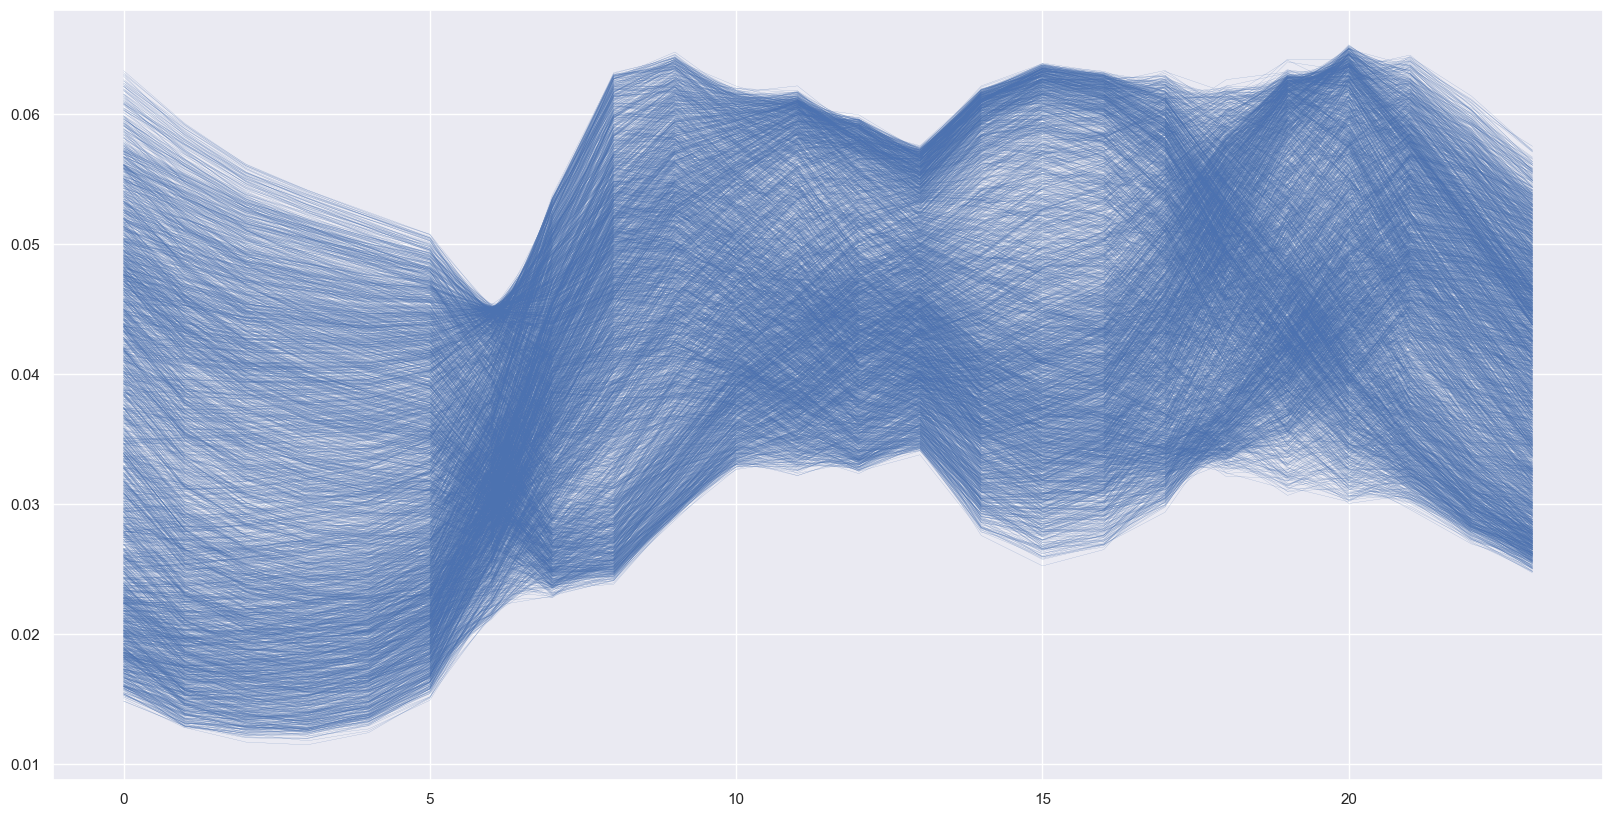

In [149]:
n_clean_runs = W_results_clean.shape[2]
fig, ax = plt.subplots(figsize=(20, 10))

for i in range(n_clean_runs):
    for k in range(n_components):
        line, = ax.plot(H_results_clean[k, :, i], linewidth=0.1, color=colors[0])

In [150]:
H_results_flat = H_results_clean.transpose([0, 2, 1]).reshape((n_components * n_clean_runs, p)) # Flattening the array of profiles
kmeans = KMeans(n_clusters=n_components, n_init=10).fit(H_results_flat)

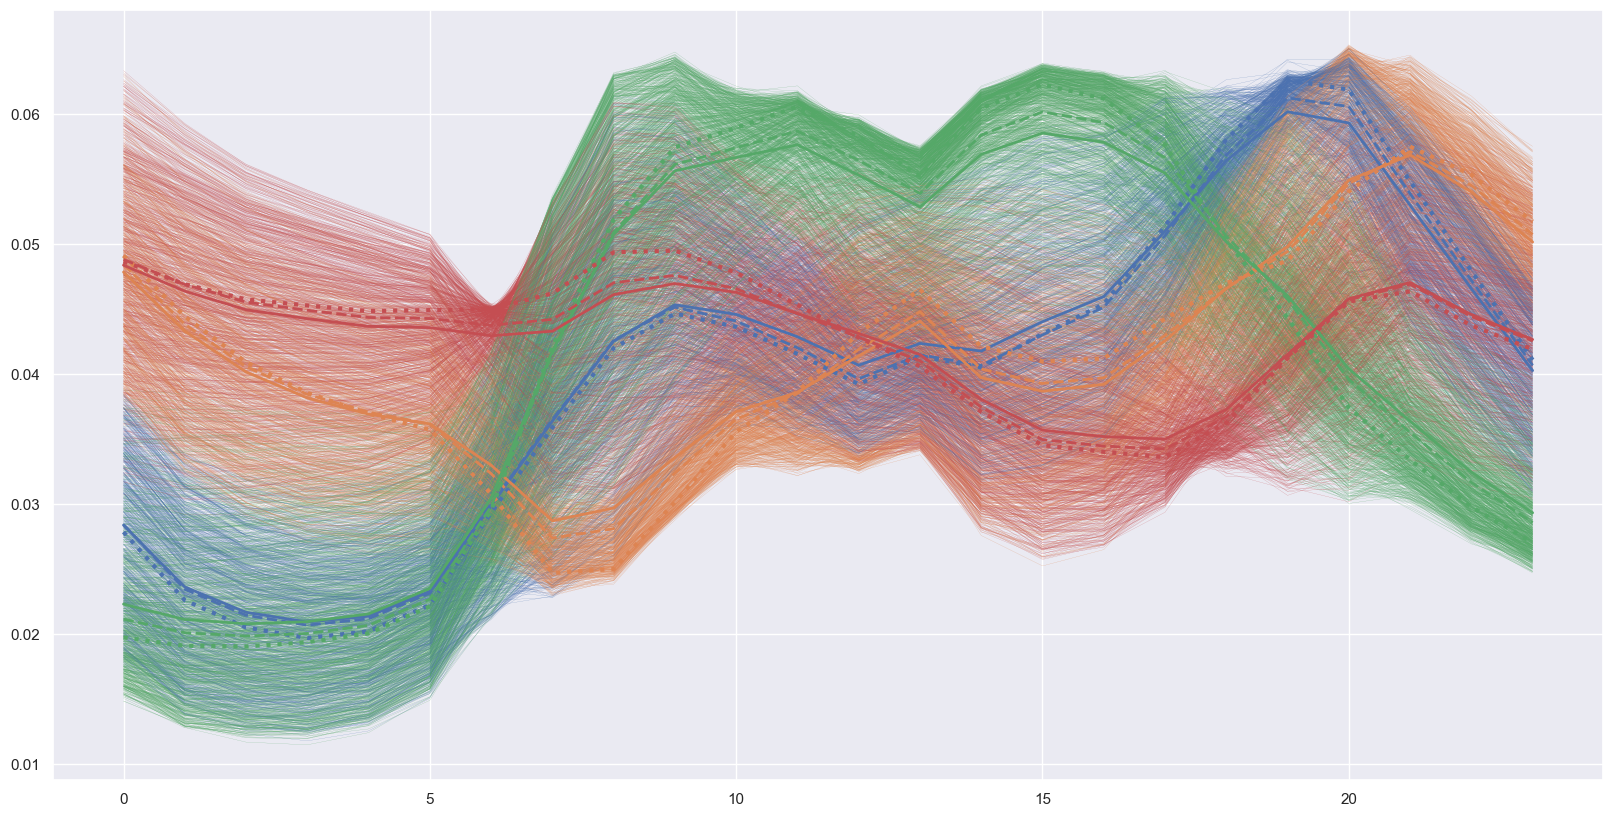

In [151]:
fig, ax = plt.subplots(figsize=(20, 10))

# Plot each profile curve coloring per cluster
for i in range(n_components * n_clean_runs):
    cluster_label = kmeans.labels_[i]
    ax.plot(H_results_flat[i, :], linewidth=0.1, color=colors[cluster_label])

# Plot cluster centroids
for i in range(n_components):
    ax.plot(kmeans.cluster_centers_[i, :], linewidth=2, color=colors[i])
    ax.plot(geometric_median(H_results_flat[kmeans.labels_ == i, :]), linewidth=2, linestyle='dashed', color=colors[i])
    ax.plot(geometric_medoid(H_results_flat[kmeans.labels_ == i, :]), linewidth=3, linestyle='dotted', color=colors[i])
    

Let's plot per cluster

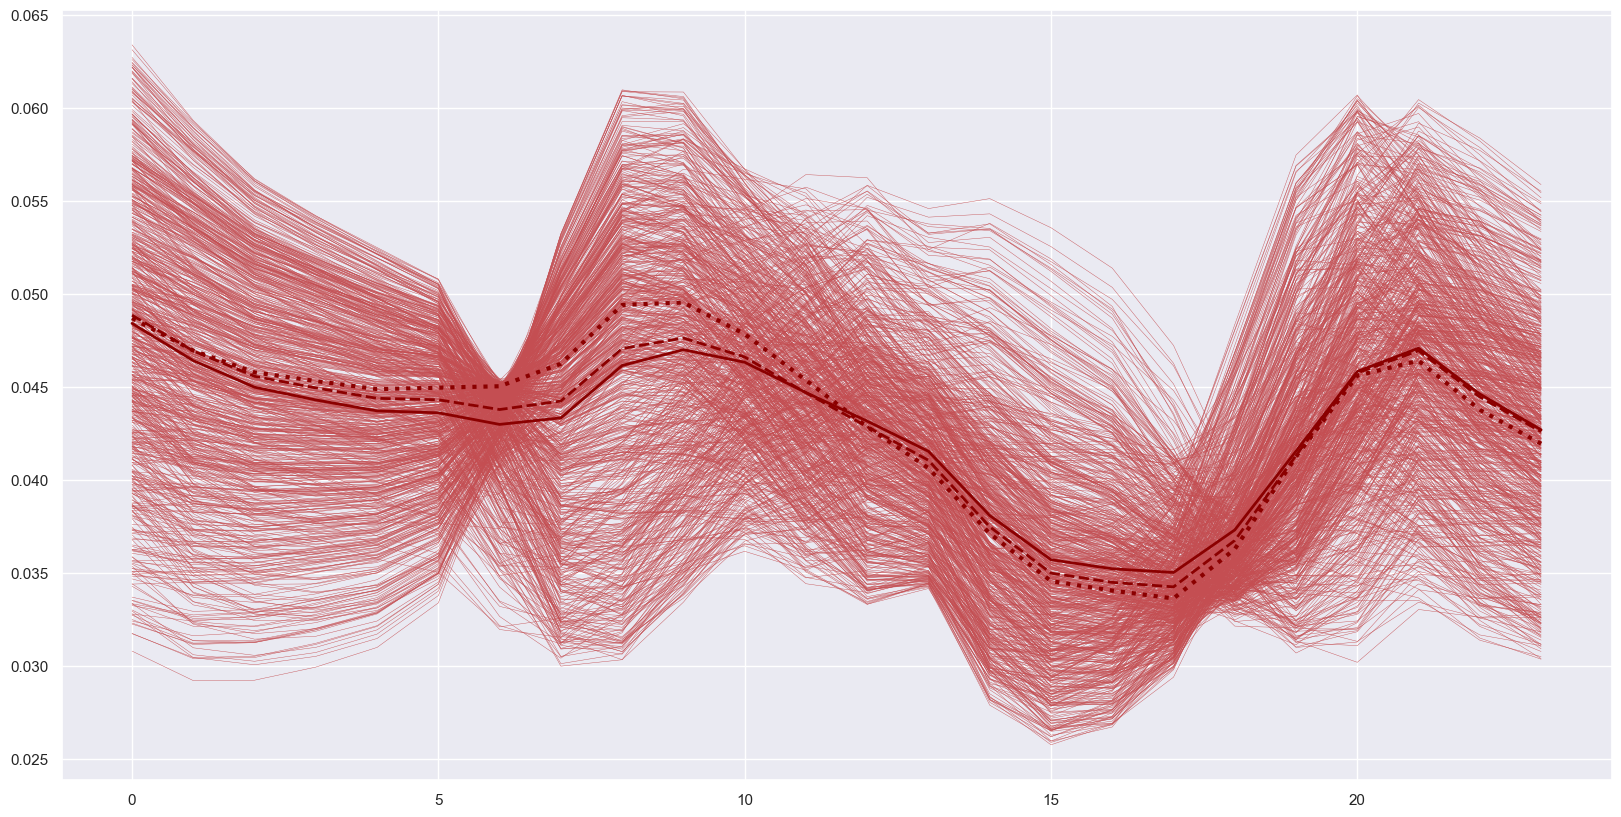

In [155]:
cluster = 3
fig, ax = plt.subplots(figsize=(20, 10))

# Plot each profile curve coloring per cluster
for i in range(n_components * n_clean_runs):
    cluster_label = kmeans.labels_[i]
    if cluster_label == cluster:
        ax.plot(H_results_flat[i, :], linewidth=0.3, color=colors[cluster_label])

# Plot cluster centroids
color = 'darkred'
# color = colors[cluster]
ax.plot(kmeans.cluster_centers_[cluster, :], linewidth=2, color=color)
ax.plot(geometric_median(H_results_flat[kmeans.labels_ == cluster, :]), linewidth=2, linestyle='dashed', color=color)
ax.plot(geometric_medoid(H_results_flat[kmeans.labels_ == cluster, :]), linewidth=3, linestyle='dotted', color=color)

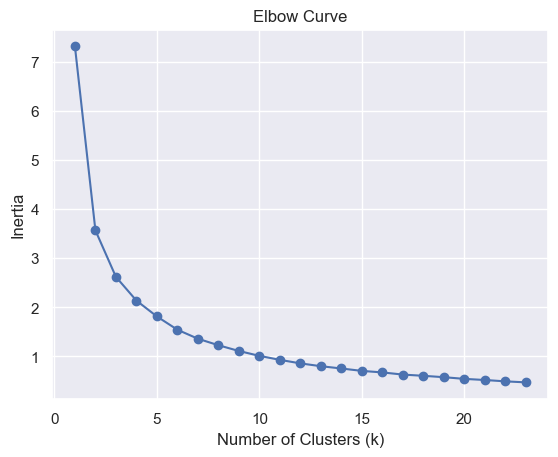

In [136]:
# Seems that there are more than 4 clusters of profiles. Let's try to find how much:

# Calculate inertia for different values of k
inertias = []
k_values = range(1, 24)
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(H_results_flat)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()

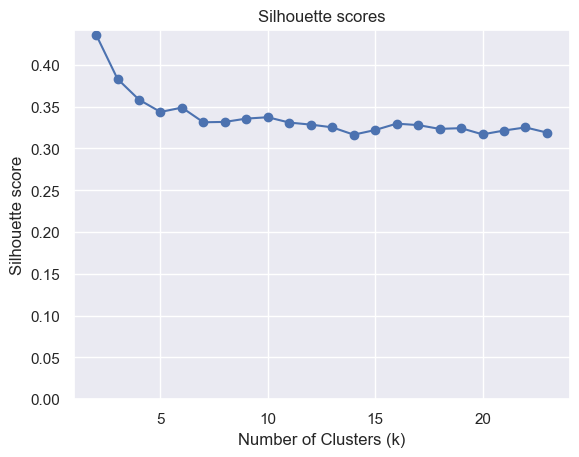

In [137]:
# Calculate silhouette score for different values of k
silhouette_scores = []
k_values = range(2, 24)
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(H_results_flat)
    labels = kmeans.labels_
    score = silhouette_score(H_results_flat, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette scores')
plt.ylim(bottom=0)
plt.show()

<Axes: >

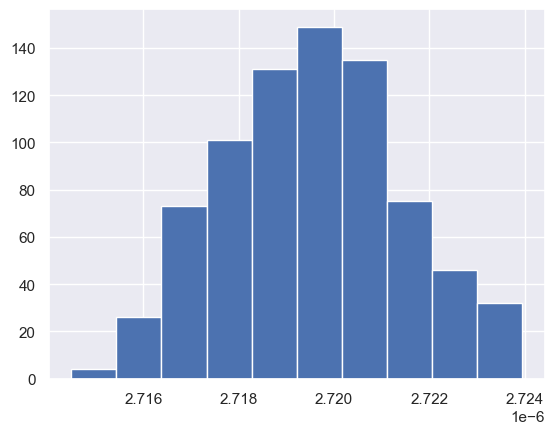

In [138]:
pd.Series(errors[iterations > 100]).hist()

<Axes: >

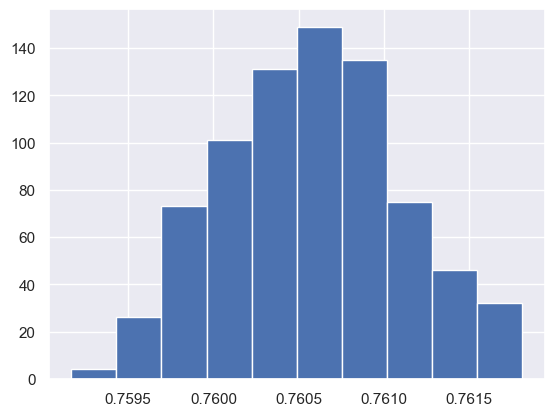

In [157]:
pd.Series(errors[iterations > 100]*X.size).hist()

___

# TESTS

In [174]:
W_init = initialize_W(X, n_components)
H_init = np.ones((n_components, p)) / p

WH_init = np.dot(W_init, H_init)

# Compute the Frobenius norm between X and the product W_init * H_init
frobenius_norm = np.linalg.norm(X - WH_init, 'fro')

print("Frobenius Norm:", frobenius_norm)
print("Frobenius Norm W_init:", np.linalg.norm(W_init, 'fro'))


Frobenius Norm: 3.7358385772724887
Frobenius Norm W_init: 61.793398997675155


In [159]:
np.linalg.norm(X, 'fro')

22.34945539699131